In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras import backend as K

import tensorflow as tf

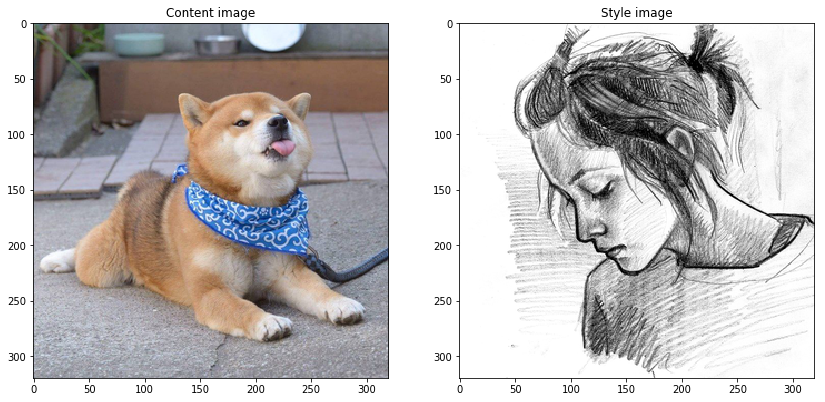

In [3]:
# Read in shiba.jpg as content image
def imread(fname, size=(320, 320)):
    im = Image.open(fname)
    im = im.crop((0, 0, min(im.size), min(im.size)))
    im.thumbnail(size, Image.ANTIALIAS)
    im = np.array(im)
    return im
    
content_im = imread('shiba.jpg')
style_im = imread('sketch.jpg')

plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.title('Content image')
plt.imshow(content_im)

plt.subplot(1, 2, 2)
plt.title('Style image')
plt.imshow(style_im)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


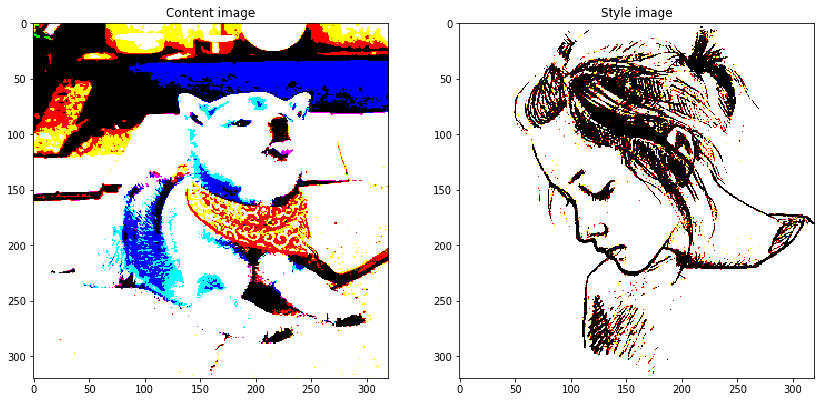

In [4]:
# preprocess images
content_im = preprocess_input(content_im).reshape(1, 320, 320, 3)
style_im = preprocess_input(style_im).reshape(1, 320, 320, 3)

plt.figure(figsize=(14, 14))
plt.subplot(1, 2, 1)
plt.title('Content image')
plt.imshow(content_im[0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Style image')
plt.imshow(style_im[0], cmap='gray')
plt.show()

In [5]:
# Import VGG16 with pre-trained ImageNet weights.
model = VGG16(weights='imagenet', include_top=False)
print('VGG16 Architecture:')
model.summary()

VGG16 Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0

In [6]:
def gram(x):
    features = K.batch_flatten(K.permute_dimensions(x[0], (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / (128**2)

layers = ['block1_conv1', 'block1_conv2',
          'block2_conv1', 'block2_conv2',
          'block3_conv1']

# calculate output of style image
grams = []
for name in layers:
    style_model = Model(inputs=model.input, outputs=model.get_layer(name).output)
    grams += [gram(style_model.predict(style_im))]

In [7]:
# A loss function that measures the style loss at multiple levels
# Also, compute the gradients w.r.t. the input image of both losses and combines to single gradient.
total_loss, gradients = 0, None
for layer, style_gram in zip(layers, grams):
    output = model.get_layer(layer).output
    loss = K.mean(K.square(gram(output) - style_gram))
    total_loss += loss
    
    gradient = K.gradients(loss, model.input)[0]
    if gradients is not None:
        gradients += gradient
    else:
        gradients = gradient
gradients = tf.clip_by_norm(gradients, 1)

# Create a function that returns the to-be maximized activation and gradients
update = K.function([model.input], [total_loss, gradients])

In [9]:
# start with initial image
init = np.copy(content_im)

# Run gradient descent to enhance image features
lr = 200
for i in range(300):
    loss, gradient = update([init])
    init -= lr * gradient
    
    print('iter {}: Current loss = {}'.format(i+1, loss))
    
    # save in /output
    result_im = init[0, :, :, ::-1]
    result_im = result_im - np.min(result_im)
    result_im = result_im * (255 / np.max(result_im))
    result_im = Image.fromarray(result_im.astype(np.uint8))
    result_im.save('output/out_{}.jpg'.format(i))

iter 1: Current loss = 48706101248.0
iter 2: Current loss = 47781076992.0
iter 3: Current loss = 46861803520.0
iter 4: Current loss = 45949845504.0
iter 5: Current loss = 45046411264.0
iter 6: Current loss = 44152856576.0
iter 7: Current loss = 43270459392.0
iter 8: Current loss = 42400489472.0
iter 9: Current loss = 41544179712.0
iter 10: Current loss = 40702828544.0
iter 11: Current loss = 39877689344.0
iter 12: Current loss = 39069884416.0
iter 13: Current loss = 38280585216.0
iter 14: Current loss = 37510709248.0
iter 15: Current loss = 36761239552.0
iter 16: Current loss = 36032933888.0
iter 17: Current loss = 35326439424.0
iter 18: Current loss = 34642350080.0
iter 19: Current loss = 33980946432.0
iter 20: Current loss = 33342466048.0
iter 21: Current loss = 32727076864.0
iter 22: Current loss = 32134502400.0
iter 23: Current loss = 31564388352.0
iter 24: Current loss = 31016304640.0
iter 25: Current loss = 30489667584.0
iter 26: Current loss = 29983756288.0
iter 27: Current loss

iter 218: Current loss = 373447712.0
iter 219: Current loss = 356539552.0
iter 220: Current loss = 340482656.0
iter 221: Current loss = 325231808.0
iter 222: Current loss = 311055424.0
iter 223: Current loss = 298647008.0
iter 224: Current loss = 289289472.0
iter 225: Current loss = 281744800.0
iter 226: Current loss = 274388640.0
iter 227: Current loss = 267626912.0
iter 228: Current loss = 261163072.0
iter 229: Current loss = 255052032.0
iter 230: Current loss = 249281840.0
iter 231: Current loss = 243637744.0
iter 232: Current loss = 238434592.0
iter 233: Current loss = 233220736.0
iter 234: Current loss = 228468896.0
iter 235: Current loss = 223660944.0
iter 236: Current loss = 219304896.0
iter 237: Current loss = 214862912.0
iter 238: Current loss = 210833056.0
iter 239: Current loss = 206736368.0
iter 240: Current loss = 202976768.0
iter 241: Current loss = 199210080.0
iter 242: Current loss = 195691968.0
iter 243: Current loss = 192211728.0
iter 244: Current loss = 188899024.0
i

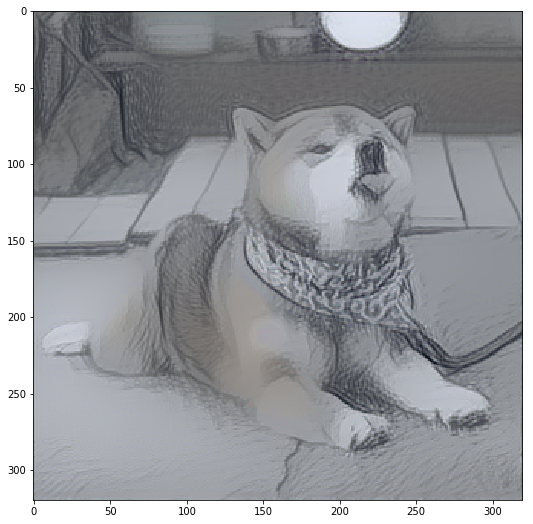

In [10]:
# normalize output to make sure that the image does not clip
init = init[0, :, :, ::-1]
init = init - np.min(init)
init = init / np.max(init)

# display image on screen
plt.figure(figsize=(9, 9))
plt.imshow(init, cmap='gray')
plt.show()